# Control theory. Course introduction.

## TP3. Controllability and Observability
## Study load

Course grade breakdown:

    Labs - 40%
    
    Final project presentation 30%

    Final test 30%
    
File name for lab submission: yourname_labnumber.ipynb (example: elenavanneaux_TP2.ipynb)    

The completed notebooks should be **submitted via the corresponding Moodle assignments before the beginning of the next session.**

## Prerequisites for practice
### Math
During the course, we will cover the following areas of mathematics:
    
    1. Linear Algebra

    2. Calculus

    3. Differential equations

    4. Dynamics (Mechanics and Physics)

### Python programming
In the labs we will use a Python programming language and the following libraries:

    1. NumPy https://numpy.org/doc/stable/

    2. SciPy https://docs.scipy.org/doc/scipy/

    3. Matplotlib https://matplotlib.org/stable/tutorials/index

    4. SymPy https://docs.sympy.org/latest/tutorials/intro-tutorial/intro.html

    5. Control System Library https://python-control.readthedocs.io/en/0.10.1/intro.html

### Jupyter Notebook Markdown Cells Documentation

Please check on Markdown cells documentation, to provide a fancy look for your notebooks!

https://jupyter-notebook.readthedocs.io/en/stable/examples/Notebook/Working%20With%20Markdown%20Cells.html

## Code template

In [3]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# x is a state vecot, t is a current time, A is a dynamic matrix, B is a control matrix, D is a disturbance matrix, 
# u_func(t) is a control input, w_func(t) is a disturbance input 
def StateSpace(x, t, A, B, D, u_func, w_func):
    w = w_func(t)
    u = u_func(t)
    return np.dot(A, x) + np.dot(B, u).flatten() + np.dot(D, w).flatten()

# OpenLoopInputOutputSystem with time-dependent w(t)
def OpenLoopInputOutputSystem(A, B, D, C, u_func, w_func, T, x0):
    # Solve the ODE system with odeint, passing the time-dependent w function
    solution = odeint(StateSpace, x0, T, args=(A, B, D, u_func, w_func))
    # Output calculation using C and the solution
    # return (C @ solution.T) 
    return (solution.T) 

def PID(A, B, D, C, Kp, Ki, Kd, r_func, w_func, T, x0):
    z0 = np.array([[0.0]])
    x_a =  np.block([[x0.reshape(-1,1)],[z0]])
    M = np.eye(x0.shape[0]) + Kd*B @ C
    A_a = np.block([[np.linalg.inv(M) @ (A - Kp * B @ C), -Ki * np.linalg.inv(M) @ B ], [C, np.array([0.0])]])
    B_a =  np.block([[Kp * np.linalg.inv(M) @ B ], [np.array([1.0])]])
    D_a = np.block([[np.linalg.inv(M) @ D],[np.array([[0.0]])]])
    C_a = np.block([C, np.array([[0.0]])])
    return OpenLoopInputOutputSystem(A_a, B_a, D_a, C_a, r_func, w_func, T, x_a.flatten()).T

Text(0, 0.5, 'Position ')

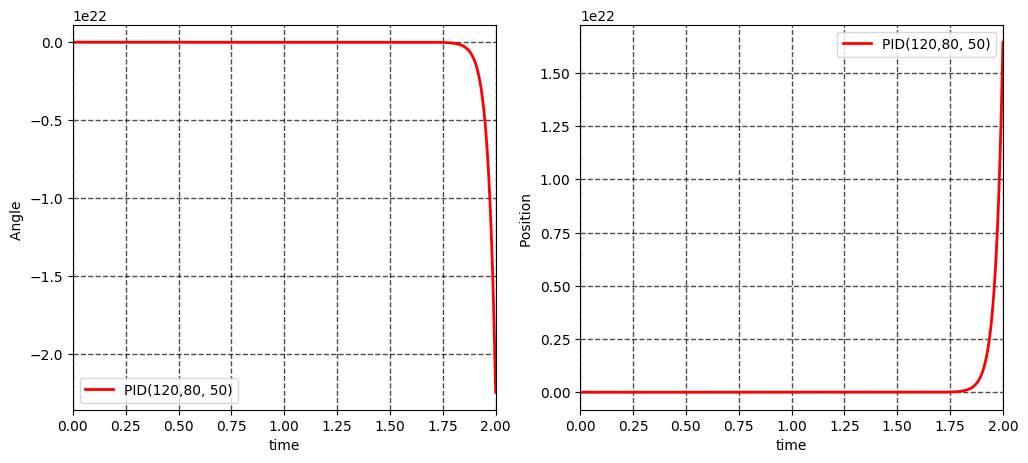

In [4]:
import sympy as sp
from matplotlib.pyplot import *
# Answer to EX1 q1 using symbolic calculus
# Define symbolic variables
M, m, b, l, I, g, F = sp.symbols('M m b l I g F')
y, y1, theta, theta1, doty1, dottheta1 = sp.symbols('y y1 theta theta1 doty1 dottheta1')

# Define the differential equations of the system
eq1 = (M+m)*doty1 + b*y1 + m*l*dottheta1*sp.cos(theta) - m*l*theta1**2*sp.sin(theta) - F
eq2 = m*l*sp.cos(theta)*doty1 + (I+m*l**2)*dottheta1 - m*g*l*sp.sin(theta)

# Solve for the first derivative of theta1 (angular velocity)
dottheta1_sol = sp.solve(eq2, dottheta1)[0]

# Solve for the first derivative of y1 (linear velocity)
doty1_sol = sp.simplify(sp.solve(eq1.subs(dottheta1, dottheta1_sol), doty1)[0])
dottheta1_sol = sp.simplify(dottheta1_sol.subs(doty1,doty1_sol))

# Define the state-space representation of the system dynamics
f1 = y1
f2 = doty1_sol 
f3 = theta1
f4 = dottheta1_sol
f = sp.Matrix([f1, f2, f3, f4])

# Define state and control variables
variables_x = sp.Matrix([y,y1,theta,theta1])
variables_u = sp.Matrix([F])

# Compute the Jacobian matrices of the system
jacobian_A = sp.simplify(f.jacobian(variables_x).subs([(theta,0), (theta1,0)]))
jacobian_B = sp.simplify(f.jacobian(variables_u).subs([(theta,0), (theta1,0)]))

A = np.array(jacobian_A.subs({M:2.5, m:0.2, b:0.1,l:0.7, I:0.006, g:9.81}).evalf()).astype(float)
B = np.array(jacobian_B.subs({M:2.5, m:0.2, b:0.1,l:0.7, I:0.006, g:9.81}).evalf()).astype(float).reshape(4,1)
C = np.array([[1,0,0,0],[0,0,1,0]]) 
D = B

x0 = np.array([0,
               0,
               0,
               0])  # initial state

MatC = np.array([[0,0,1,0]]) # Let us assume that we measure only theta
y_ref = 1 # and we want to track constant reference equal to 1 rad. The latter correspond a state responce if the system

Kp= 120;
Ki = 80;
Kd = 50;

t0 = 0 # Initial time 
tf = 2 # Final time
T = np.linspace(t0, tf, 1000) 

def w_func(t):
       return 1.0# Disturbance input

def r_func(t):
       return 0.0# Disturbance input


solution = PID(A, B, D, MatC , Kp, Ki, Kd, r_func, w_func, T, x0)


figure(figsize=(12, 5))
y = solution[:,2]

subplot(1, 2, 1)
plot(T, y, linewidth=2.0, color = 'red')
grid(color='black', linestyle='--', linewidth=1.0, alpha = 0.7)
grid(True)
xlabel('time')
xlim([t0, tf])
plt.legend(['PID(120,80, 50)' ])
ylabel(r'Angle ')

y = solution[:,0]
subplot(1, 2, 2)
plot(T, y, linewidth=2.0, color = 'red')
grid(color='black', linestyle='--', linewidth=1.0, alpha = 0.7)
grid(True)
xlim([t0, tf])
xlabel('time')
plt.legend(['PID(120,80, 50)' ])
ylabel(r'Position ')

## Ex 1. Duality of Controllability and Observability

Prove that a pair of matrices (A,B) is controllable if and only if a pair of matrices (A^T, B^T) is observable.

**Proof of Duality** 

Controllability and ObservabilityTo demonstrate that a system's controllability implies the observability of its dual pair, we analyze the properties of the matrices associated with the state-space system $\dot{x} = Ax + Bu$.1. 

1. Definition of Controllability

The necessary and sufficient condition for the pair $(A, B)$ to be controllable is that its controllability matrix:

$$\mathcal{C}(A,B) = \begin{bmatrix} B & AB & A^2B & \dots & A^{n-1}B \end{bmatrix}$$

has full rank ($rank = n$), where $n$ represents the dimension of the state vector.

2. Analysis of the Dual PairWhen considering the dual pair $(A^T, B^T)$, the structure of the corresponding observability matrix, $\mathcal{O}(A^T, B^T)$, is defined as:

$$\mathcal{O}(A^T, B^T) = \begin{bmatrix} B^T \\ B^T A^T \\ \vdots \\ B^T (A^T)^{n-1} \end{bmatrix} = \begin{bmatrix} B^T \\ (AB)^T \\ \vdots \\ (A^{n-1}B)^T \end{bmatrix}$$

3. Transposition and Rank RelationshipIt is evident that the observability matrix of the dual pair is the transpose of the original controllability matrix:

$$\mathcal{O}(A^T, B^T) = \mathcal{C}(A, B)^T$$According to the fundamental property of linear algebra where the rank of a matrix is equal to the rank of its transpose ($\operatorname{rank}(M) = \operatorname{rank}(M^T)$), it follows that:$$\operatorname{rank} \mathcal{O}(A^T, B^T) = \operatorname{rank} \mathcal{C}(A, B)$$Conclusion: The original system $(A, B)$ is controllable if and only if the dual system $(A^T, B^T)$ is observable.

## Ex 2. Invariance Under Nonsingular Transformations.

Consider $\dot x = Ax + Bu$ and similarity transformation $\tilde x = Tx$, where $T$ is invertible.

Prove that the system $\dot x = Ax + Bu$ is controllable if and only if the system  $\dot {\tilde x} = \tilde{A}\tilde{x} + \tilde{B}u$ is controllable.

## Proof of Invariance Under Nonsingular Transformations

Consider the system $\dot{x} = Ax + Bu$ and the similarity transformation $\tilde{x} = Tx$, where $T$ is an invertible matrix. The transformed system becomes:

$$
\dot{\tilde{x}} = \tilde{A}\tilde{x} + \tilde{B}u,
$$

where $\tilde{A} = TAT^{-1}$ and $\tilde{B} = TB$. We aim to prove that the controllability of $(A, B)$ implies the controllability of $(\tilde{A}, \tilde{B})$.

### Proof
1. **Controllability Matrix for $(A, B)$:**
   The controllability matrix for the original system is:
   $$
   \mathcal{C}(A, B) = \begin{bmatrix} B & AB & A^2B & \dots & A^{n-1}B \end{bmatrix}.
   $$

2. **Controllability Matrix for $(\tilde{A}, \tilde{B})$:**
   Using the similarity transformation, the controllability matrix for the transformed system is:
   $$
   \mathcal{C}(\tilde{A}, \tilde{B}) = \begin{bmatrix} \tilde{B} & \tilde{A}\tilde{B} & \tilde{A}^2\tilde{B} & \dots & \tilde{A}^{n-1}\tilde{B} \end{bmatrix}.
   $$
   Substituting $\tilde{A} = TAT^{-1}$ and $\tilde{B} = TB$, we get:
   $$
   \mathcal{C}(\tilde{A}, \tilde{B}) = T \begin{bmatrix} B & AB & A^2B & \dots & A^{n-1}B \end{bmatrix}.
   $$

3. **Rank Preservation:**
   Since $T$ is invertible, the rank of $\mathcal{C}(\tilde{A}, \tilde{B})$ is the same as the rank of $\mathcal{C}(A, B)$. Therefore, $(A, B)$ is controllable if and only if $(\tilde{A}, \tilde{B})$ is controllable.



In [6]:
import numpy as np
from scipy.linalg import inv

# Define the similarity transformation matrix T
T = np.array([[1, 2, 0, 0], 
              [0, 1, 0, 0], 
              [0, 0, 1, 2], 
              [0, 0, 0, 1]])  # Adjusted to match the dimensions of A and B

# Define the original state-space matrices A and B (already defined in the notebook)
# Using the matrices A and B from the symbolic computation above

# Compute the transformed matrices
A_tilde = T @ A @ inv(T)
B_tilde = T @ B

# Define a function to compute the controllability matrix
def controllability_matrix(A, B):
    n = A.shape[0]
    return np.hstack([np.linalg.matrix_power(A, i) @ B for i in range(n)])

# Compute the controllability matrices
C_original = controllability_matrix(A, B)
C_transformed = controllability_matrix(A_tilde, B_tilde)

# Check the ranks of the controllability matrices
rank_original = np.linalg.matrix_rank(C_original)
rank_transformed = np.linalg.matrix_rank(C_transformed)

print("Rank of original controllability matrix:", rank_original)
print("Rank of transformed controllability matrix:", rank_transformed)
assert rank_original == rank_transformed, "Ranks do not match!"

print("The system is controllable under the similarity transformation.")

Rank of original controllability matrix: 4
Rank of transformed controllability matrix: 4
The system is controllable under the similarity transformation.


## Ex 3. Quadruple-Tank Process

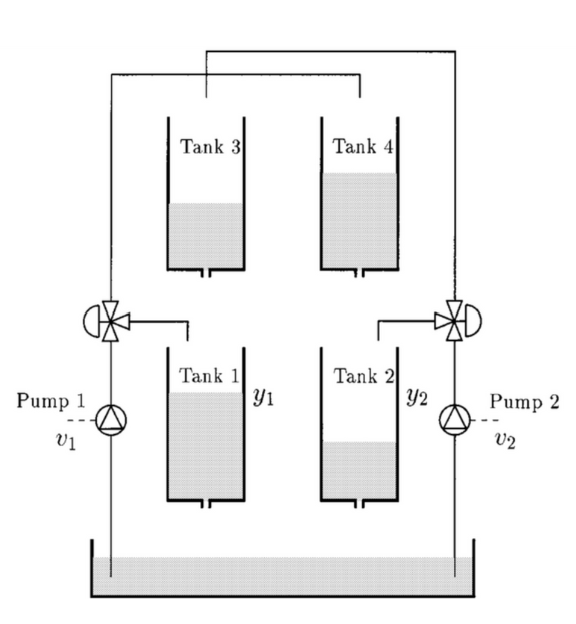

Let us consider the Quadruple-Tank Process. A schematic diagram of the process is shown in the Figure above. The
target is to control the level in the lower two tanks with two pumps. The process inputs are $v_1$ and $v_2$ (input voltages to the pumps) and the outputs are $y_1$ and $y_2$ (water levels in the lower two tanks). Mass balances and Bernoulli’s law yield:

$$
\dfrac{dh_1}{dt} = -\dfrac{a_1}{A_1}\sqrt{2gh_1} + \dfrac{a_3}{A_1}\sqrt{2gh_3} + \dfrac{\gamma_1k_1}{A_1}v_1 = f_1(h_1,h_2,h_3,h_4,v_1,v_2)
$$
$$
\dfrac{dh_2}{dt} = -\dfrac{a_2}{A_2}\sqrt{2gh_2} + \dfrac{a_4}{A_2}\sqrt{2gh_4} + \dfrac{\gamma_2k_2}{A_2}v_2 = f_2(h_1,h_2,h_3,h_4,v_1,v_2)
$$
$$
\dfrac{dh_3}{dt} = -\dfrac{a_3}{A_3}\sqrt{2gh_3} + \dfrac{(1-\gamma_2)k_2}{A_3}v_2 = f_3(h_1,h_2,h_3,h_4,v_1,v_2)
$$
$$
\dfrac{dh_4}{dt} = -\dfrac{a_4}{A_4}\sqrt{2gh_4} + \dfrac{(1-\gamma_1)k_1}{A_4}v_1 = f_4(h_1,h_2,h_3,h_4,v_1,v_2)
$$
where

$A_i$ is a cross-section of Tank i

$a_i$ is a cross-section of outlet hole of Tank i

$h_i$ is a water level.

The voltage applied to Pump $i$ is $v_i$ and the corresponding flow
is $k_iv_i$. The parameters $\gamma_1,\gamma_2\in (0,1)$ are determined from how the valves are set prior to the experiment. The flow to Tank 1
is $\gamma_1k_1v_1$ and the flow to Tank 4 is $(1-\gamma_1)k_1v_1$ and similarly
for Tank 2 and Tank 3. The acceleration of gravity is denoted $g$.
The measured level signals are $k_c h_1$ and $k_c h_2$. The parameter
values of the laboratory process are given in the following table

    A_1, A_3 [cm^2] 28
    A_2, A_4 [cm^2] 32
    a_1, a_3 [cm^2] 0.071
    a_2, a_4 [cm^2] 0.057
    k_c [V/cm] 0.50
    g [cm/s^2] 9.81
    k_1 [cm^3/Vs] 3.33
    k_2 [cm^3/Vs] 3.35
    gamma_1 0.70
    gamma_2 0.60
    
Check the following paper for more details on the model. 
https://www.diva-portal.org/smash/get/diva2:495784/FULLTEXT01.pdf
    
## TODO
1. Linearise the system around the operating point 
$$(h_1^0,h_2^0,h_3^0,h_4^0, v_1^0, v_2^0) = (12.4,12.7,1.8,1.4,3.00,3.00).$$
Pass to shifted variables $x_i = h_i-h_i^0, u_i = v_i - v_i^0.$

2. Is the linear system controllable? Is the linear system observable? Use the Kalman rank test to answer this question.

3. Imagine that one of the pumps is broken and there is no flow through it. Does the system remain controllable?

4. Let us measure the signals $x_3, x_4$ (i.e. matrix $C = \begin{pmatrix}0&0&1&0\\0&0&0&1\end{pmatrix}$) instead of measuring the signals $x_1$ and $x_2.$ Is such a system observable?

**Remark.** The functions control.ctrb and control.obsv from the control system library might be useful to complete this exercise. https://python-control.readthedocs.io/en/0.10.1/generated/control.obsv.html 

In [15]:
#Linearization 

#Linearizing around an operating point $$(h_1^0,h_2^0,h_3^0,h_4^0, v_1^0, v_2^0) = (12.4,12.7,1.8,1.4,3.00,3.00).$$ and introducing Dh_i = h_i-h_i^0 and Du_i = u_i-u_i^0, yield the linear equations: 

import numpy as np
import control as ct
import sympy as sp

#Linearization using jacobian matrices
h1, h2, h3, h4, v1, v2 = sp.symbols('h1 h2 h3 h4 v1 v2')
A1, A2, A3, A4, a1, a2, a3, a4 = sp.symbols('A1 A2 A3 A4 a1 a2 a3 a4')
gs, k1s, k2s, g1, g2 = sp.symbols('g k1 k2 gamma1 gamma2')
T1, T2, T3, T4 = sp.symbols('T1 T2 T3 T4')

x_sym = sp.Matrix([h1, h2, h3, h4])
u_sym = sp.Matrix([v1, v2])

f1 = -(a1/A1)*sp.sqrt(2*gs*h1) + (a3/A1)*sp.sqrt(2*gs*h3) + (g1*k1s/A1)*v1
f2 = -(a2/A2)*sp.sqrt(2*gs*h2) + (a4/A2)*sp.sqrt(2*gs*h4) + (g2*k2s/A2)*v2
f3 = -(a3/A3)*sp.sqrt(2*gs*h3) + ((1-g2)*k2s/A3)*v2
f4 = -(a4/A4)*sp.sqrt(2*gs*h4) + ((1-g1)*k1s/A4)*v1

f_sym = sp.Matrix([f1, f2, f3, f4])

jac_A_sym = f_sym.jacobian(x_sym)
jac_B_sym = f_sym.jacobian(u_sym)






#Operation point
h0 = np.array([12.4, 12.7, 1.8, 1.4])
v0 = np.array([3.0, 3.0])

#Parameters 
A_pts = np.array([28.0, 32.0, 28.0, 32.0])
a_pts= np.array([0.071, 0.057, 0.071, 0.057])
g = 9.81
k = [3.33, 3.35]
kc = 0.5
gamma = [0.7, 0.6]

#based on the article
#Calculation of Ti

# Ti = (Ai/ai) * sqrt(2*hi0 / g)
Ti = (np.array(A_pts) / np.array(a_pts)) * np.sqrt((2 * h0) / g)

print("--- Linears Equations---")
for i in range(4):
    eq_lin = 0
    # Parte Ax
    for j in range(4):
        if jac_A_sym[i,j] != 0:
            # Substituindo o termo derivado pela constante de tempo Ti para clareza
            term = jac_A_sym[i,j].subs(sp.sqrt(2*gs*x_sym[j]), (A_pts[j]*2*h0[j])/(a_pts[j]*Ti[j])) # Simplificação conceitual
            eq_lin += jac_A_sym[i,j] * sp.symbols(f'x{j+1}')
    
    # Parte Bu
    for j in range(2):
        if jac_B_sym[i,j] != 0:
            eq_lin += jac_B_sym[i,j] * sp.symbols(f'u{j+1}')
            
    print(f"dx{i+1}/dt = {sp.simplify(eq_lin)}")

    

 
#The linearized matrix are: 

A_lin = np.array([
    [-1/Ti[0], 0,          A_pts[2]/(A_pts[0]*Ti[2]), 0],
    [0,         -1/Ti[1], 0,                         A_pts[3]/(A_pts[1]*Ti[3])],
    [0,         0,         -1/Ti[2],                0],
    [0,         0,         0,                        -1/Ti[3]]
])


B_lin = np.array([
    [(gamma[0]*k[0])/A_pts[0], 0],
    [0,                        (gamma[1]*k[1])/A_pts[1]],
    [0,                        ((1-gamma[1])*k[1])/A_pts[2]],
    [((1-gamma[0])*k[0])/A_pts[3], 0]
])


# y = [kc 0 0 0; 0 kc 0 0] * x
C_lin = np.array([
    [kc, 0,  0, 0],
    [0,  kc, 0, 0]
])

# --- Results ---
print("Time Constants(T1, T2, T3, T4):")
print(Ti)
print("\nMatrix A:")
print(np.round(A_lin, 5))
print("\nMatrix B:")
print(np.round(B_lin, 5))

#Matrix Co (Contrability)
Co = ct.ctrb(A_lin, B_lin)
rank_Co = np.linalg.matrix_rank(Co)
print("\nMatrix of Controlability (Co):")
print(np.round(Co, 5))
print("\nControlability matrix rank:", rank_Co)

#Matrix Ob (Observability)
Ob = ct.obsv(A_lin, C_lin)
rank_Ob = np.linalg.matrix_rank(Ob)
print("\nMatrix of Observability (Ob):")
print(np.round(Ob, 5))
print("\nRank of Observability matrix:", rank_Ob)



if rank_Co == A_lin.shape[0]:
    print("\nThe system is controllable.")
else:
    print("\nThe system is not controllable.") 

if rank_Ob == A_lin.shape[0]:
    print("\nThe system is observable.")
else:
    print("\nThe system is not observable.")


 



--- Linears Equations---
dx1/dt = -sqrt(2)*a1*x1*sqrt(g*h1)/(2*A1*h1) + sqrt(2)*a3*x3*sqrt(g*h3)/(2*A1*h3) + gamma1*k1*u1/A1
dx2/dt = -sqrt(2)*a2*x2*sqrt(g*h2)/(2*A2*h2) + sqrt(2)*a4*x4*sqrt(g*h4)/(2*A2*h4) + gamma2*k2*u2/A2
dx3/dt = (-sqrt(2)*a3*x3*sqrt(g*h3)/2 - h3*k2*u2*(gamma2 - 1))/(A3*h3)
dx4/dt = (-sqrt(2)*a4*x4*sqrt(g*h4)/2 - h4*k1*u1*(gamma1 - 1))/(A4*h4)
Time Constants(T1, T2, T3, T4):
[627.03389734 903.35297108 238.90015379 299.92981154]

Matrix A:
[[-0.00159  0.       0.00419  0.     ]
 [ 0.      -0.00111  0.       0.00333]
 [ 0.       0.      -0.00419  0.     ]
 [ 0.       0.       0.      -0.00333]]

Matrix B:
[[0.08325 0.     ]
 [0.      0.06281]
 [0.      0.04786]
 [0.03122 0.     ]]

Matrix of Controlability (Co):
[[ 8.325e-02  0.000e+00 -1.300e-04  2.000e-04  0.000e+00 -0.000e+00
  -0.000e+00  0.000e+00]
 [ 0.000e+00  6.281e-02  1.000e-04 -7.000e-05 -0.000e+00  0.000e+00
   0.000e+00 -0.000e+00]
 [ 0.000e+00  4.786e-02  0.000e+00 -2.000e-04  0.000e+00  0.000e+00
   0.

In [16]:
# Simulate the scenario where pump 1 is broken (no flow through pump 1)
B_lin_pump1_broken = B_lin.copy()
B_lin_pump1_broken[:, 0] = 0  # Set the first column to zero

# Recompute controllability matrix and rank
Co_pump1_broken = ct.ctrb(A_lin, B_lin_pump1_broken)
rank_Co_pump1_broken = np.linalg.matrix_rank(Co_pump1_broken)

print("\nMatrix of Controllability (Co) with Pump 1 Broken:")
print(np.round(Co_pump1_broken, 5))
print("\nControlability matrix rank with Pump 1 Broken:", rank_Co_pump1_broken)

if rank_Co_pump1_broken == A_lin.shape[0]:
    print("\nThe system is controllable with Pump 1 broken.")
else:
    print("\nThe system is not controllable with Pump 1 broken.")

# Simulate the scenario where pump 2 is broken (no flow through pump 2)
B_lin_pump2_broken = B_lin.copy()
B_lin_pump2_broken[:, 1] = 0  # Set the second column to zero

# Recompute controllability matrix and rank
Co_pump2_broken = ct.ctrb(A_lin, B_lin_pump2_broken)
rank_Co_pump2_broken = np.linalg.matrix_rank(Co_pump2_broken)

print("\nMatrix of Controllability (Co) with Pump 2 Broken:")
print(np.round(Co_pump2_broken, 5))
print("\nControlability matrix rank with Pump 2 Broken:", rank_Co_pump2_broken)

if rank_Co_pump2_broken == A_lin.shape[0]:
    print("\nThe system is controllable with Pump 2 broken.")
else:
    print("\nThe system is not controllable with Pump 2 broken.")


Matrix of Controllability (Co) with Pump 1 Broken:
[[ 0.000e+00  0.000e+00  0.000e+00  2.000e-04  0.000e+00 -0.000e+00
   0.000e+00  0.000e+00]
 [ 0.000e+00  6.281e-02  0.000e+00 -7.000e-05  0.000e+00  0.000e+00
   0.000e+00 -0.000e+00]
 [ 0.000e+00  4.786e-02  0.000e+00 -2.000e-04  0.000e+00  0.000e+00
   0.000e+00 -0.000e+00]
 [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00
   0.000e+00  0.000e+00]]

Controlability matrix rank with Pump 1 Broken: 3

The system is not controllable with Pump 1 broken.

Matrix of Controllability (Co) with Pump 2 Broken:
[[ 0.08325  0.      -0.00013  0.       0.       0.      -0.       0.     ]
 [ 0.       0.       0.0001   0.      -0.       0.       0.       0.     ]
 [ 0.       0.       0.       0.       0.       0.       0.       0.     ]
 [ 0.03122  0.      -0.0001   0.       0.       0.      -0.       0.     ]]

Controlability matrix rank with Pump 2 Broken: 3

The system is not controllable with Pump 2 broken.


In [ ]:

C_lin = np.array([
    [0, 0,  kc, 0],
    [0,  0, 0, kc]
])

#Matrix Ob (Observability)
Ob = ct.obsv(A_lin, C_lin)
rank_Ob = np.linalg.matrix_rank(Ob)
print("\nMatrix of Observability (Ob):")
print(np.round(Ob, 5))
print("\nRank of Observability matrix:", rank_Ob)

if rank_Ob == A_lin.shape[0]:
    print("\nThe system is observable.")
else:
    print("\nThe system is not observable.")




Matrix of Observability (Ob):
[[ 0.00e+00  0.00e+00  5.00e-01  0.00e+00]
 [ 0.00e+00  0.00e+00  0.00e+00  5.00e-01]
 [ 0.00e+00  0.00e+00 -2.09e-03  0.00e+00]
 [ 0.00e+00  0.00e+00  0.00e+00 -1.67e-03]
 [ 0.00e+00  0.00e+00  1.00e-05  0.00e+00]
 [ 0.00e+00  0.00e+00  0.00e+00  1.00e-05]
 [ 0.00e+00  0.00e+00 -0.00e+00  0.00e+00]
 [ 0.00e+00  0.00e+00  0.00e+00 -0.00e+00]]

Rank of Observability matrix: 2

The system is not observable.
